<a href="https://colab.research.google.com/github/Pepcoders/Data-Science-March/blob/main/NLP/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/Pepcoders/Data-Science-March/main/NLP/Sentiment.csv')

In [4]:
data

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0000,yes,1.0000,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0000,yes,1.0000,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0000,yes,1.0000,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13866,13867,No candidate mentioned,1.0000,yes,1.0000,Negative,0.7991,Abortion,0.6014,No candidate mentioned,...,yes,7,Negative,Abortion\nWomen's Issues (not abortion though),RT @cappy_yarbrough: Love to see men who will ...,NaN,2015-08-07 09:29:43 -0700,629690895479250944,Como,NaN
13867,13868,Mike Huckabee,0.9611,yes,1.0000,Positive,0.7302,None of the above,0.9229,Mike Huckabee,...,yes,1,NaN,NaN,RT @georgehenryw: Who thought Huckabee exceede...,NaN,2015-08-07 09:25:02 -0700,629689719056568320,USA,NaN
13868,13869,Ted Cruz,1.0000,yes,1.0000,Positive,0.8051,None of the above,0.9647,Ted Cruz,...,yes,67,Positive\nNeutral,NaN,"RT @Lrihendry: #TedCruz As President, I will a...",NaN,2015-08-07 07:19:18 -0700,629658075784282112,NaN,NaN
13869,13870,Donald Trump,1.0000,yes,1.0000,Negative,1.0000,Women's Issues (not abortion though),0.9202,Donald Trump,...,yes,149,NaN,Women's Issues (not abortion though),RT @JRehling: #GOPDebate Donald Trump says tha...,NaN,2015-08-07 09:54:04 -0700,629697023663546368,NaN,NaN


In [5]:
data=data[['text','sentiment']]

In [6]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.1)

In [7]:
# Removing neutral sentiments
train = train[train.sentiment != "Neutral"]

In [8]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']

In [9]:
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

Positive words


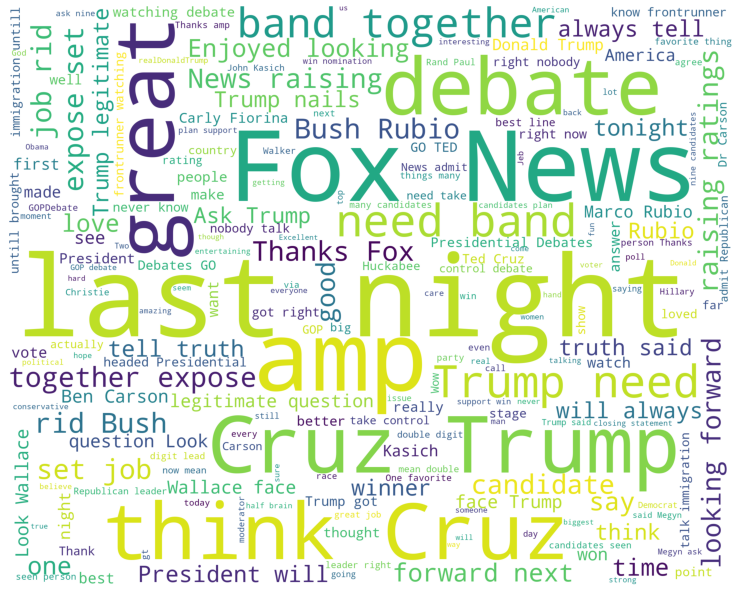

Negative words


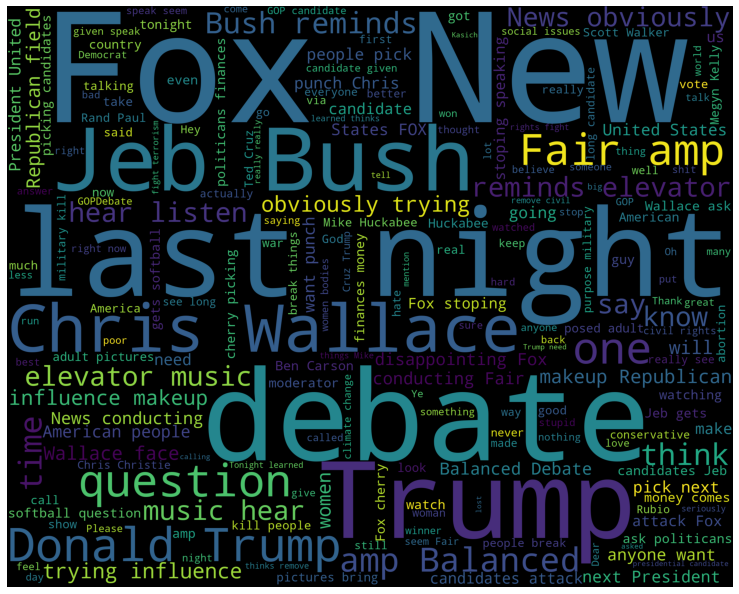

In [10]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [12]:
tweets = []
nltk.download('stopwords')
stopwords_set = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))

In [15]:
test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']

In [16]:
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

In [20]:
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features,wordlist
w_features,wordlist = get_word_features(get_words_in_tweets(tweets))

In [ ]:
wordlist

In [22]:
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

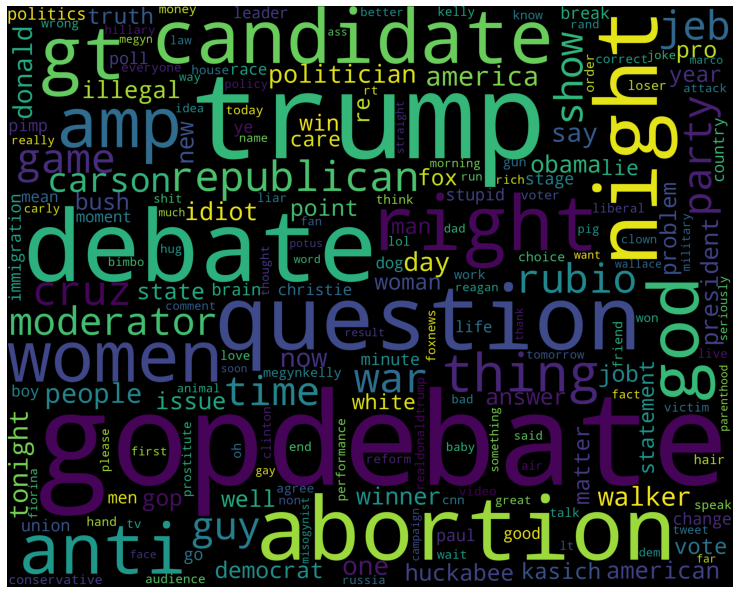

In [23]:
wordcloud_draw(w_features)

In [24]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [25]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt)) 

[Negative]: 833/796 
[Positive]: 219/73 
